In [1]:
#data source https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
TRAIN_DATA = "../data/external/train.csv"
TEST_DATA = "../data/external/test.csv"

#Target column in the data. 
TARGET = "SalePrice"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

#display all dataframe columns
pd.options.display.max_columns = None

In [3]:
train = pd.read_csv(TRAIN_DATA)

In [4]:
train.drop('Id', axis=1, inplace=True)

In [5]:
train.groupby('BsmtExposure', dropna=False).SalePrice.count()

BsmtExposure
Av     221
Gd     134
Mn     114
No     953
NaN     38
Name: SalePrice, dtype: int64

### Variable Types

In [6]:
tmp = train.dtypes
vars_cat = tmp[tmp == 'O'].index.tolist()
vars_num = [col for col in tmp.index if col not in vars_cat and col!= "SalePrice"]
vars_num.remove('MoSold')
vars_num.remove('MSSubClass')
vars_cat.extend(['MoSold', 'MSSubClass'])

vars_year = [var for var in train.columns if 'Yr' in var or 'Year' in var]
#vars_num = [var for var in vars_num if var not in vars_year]

print(len(vars_year))
print(len(vars_num))
print(len(vars_cat))

4
34
45


### Year Variables

In [7]:
# modify year variables.
def modify_year_vars(df, var, var_ref="YrSold"):
    tmp = df[var_ref] - df[var] 
    return tmp

In [8]:
var_ref = 'YrSold'
for var in vars_year:
    if var != var_ref:
        train[var] = modify_year_vars(train, var)
        
train[vars_year].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,5,5,5.0,2008
1,31,31,31.0,2007
2,7,6,7.0,2008
3,91,36,8.0,2006
4,8,8,8.0,2008


### Numerical Variables

In [9]:
#numerical varialbes with missing values
# percentage of missing values
tmp = train[vars_num].isnull().mean().sort_values(ascending=False)
tmp[tmp>0]

LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
dtype: float64

In [10]:
tmp = train[vars_num].isnull().mean().sort_values(ascending=False)
vars_num_missing = tmp[tmp>0].index.tolist()


#adding a new column flagging missing values 
# fill the missing values in the original column with mean values
for var in vars_num_missing:
    tmp = np.where(train[var].isna(), 1, 0) #(1=missing, 0=not missing)
    train[var + '_na'] = tmp
    
    
    mean = train[var].mean()
    train[var] = train[var].fillna(mean)  # fill missing values with mean value

In [11]:
# checking the new flags
#they should add up to original percentage above.
for var in vars_num_missing:
    print(var + "_na", round(train[var + '_na'].mean(), 6))

LotFrontage_na 0.177397
GarageYrBlt_na 0.055479
MasVnrArea_na 0.005479


In [12]:
#checking again for missing values in the original variables
# there should not be any missing value at this point. 
tmp = train[vars_num].isnull().mean()
tmp[tmp>0]

Series([], dtype: float64)

### Categorical Values
#### missing values

In [13]:
print("Percentage of NA values among categorical variables:")
tmp = train[vars_cat].isnull().mean() 
vars_cat_with_na = tmp[tmp>0].index
print(tmp[tmp>0].sort_values(ascending=False)); print("")


vars_cat_missing_many = tmp[tmp >= 0.1].index.tolist()
vars_cat_missing_few = [var for var in tmp[tmp>0].index.tolist() if var not in vars_cat_missing_many]


print("Missing fewer number of values:")
print(vars_cat_missing_few)
print("\nMissing a large number of values:")
print(vars_cat_missing_many)

Percentage of NA values among categorical variables:
PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

Missing fewer number of values:
['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

Missing a large number of values:
['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


Basement variables have same number of missing values. This is most likely because there is no basement for the house. Similar is the garage variables. I'll remove these variables from vars_cat_missing_few and add two new variables -- basement_missing and garage_missing. 

In [14]:
#vars_cat_missing_bsmt = [var for var in vars_cat_missing_few if 'Bsmt' in var]
#vars_cat_missing_garage = [var for var in vars_cat_missing_few if 'Garage' in var]
#vars_cat_missing_few = [var for var in vars_cat_missing_few if 'Bsmt' not in var and 'Garage' not in var]


#print(vars_cat_missing_bsmt)
#print(vars_cat_missing_garage)

In [15]:
for var in vars_cat_missing_few:
    mode = train[var].mode()[0]
    train[var] = train[var].fillna(mode)

    
for var in vars_cat_missing_many:
    train[var] = train[var].fillna("Missing")

#total number of missing categorical values
# expecting 0 values missing at this point
train[vars_cat].isnull().sum().sum()

0

In [16]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_na,GarageYrBlt_na,MasVnrArea_na
0,60,RL,65.0,8450,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,5,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Missing,Attchd,5.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,Missing,Missing,Missing,0,2,2008,WD,Normal,208500,0,0,0
1,20,RL,80.0,9600,Pave,Missing,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,31,31,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,31.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,Missing,Missing,Missing,0,5,2007,WD,Normal,181500,0,0,0
2,60,RL,68.0,11250,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,7,6,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,7.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,Missing,Missing,Missing,0,9,2008,WD,Normal,223500,0,0,0
3,70,RL,60.0,9550,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,91,36,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,8.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,Missing,Missing,Missing,0,2,2006,WD,Abnorml,140000,0,0,0
4,60,RL,84.0,14260,Pave,Missing,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,8,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,8.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,Missing,Missing,Missing,0,12,2008,WD,Normal,250000,0,0,0


#### ordinal - mapping

The following are ordinal variables. 

ExterQual, ExterCond, BsmtQual, BsmtCond, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC
BsmtExposure, BsmtFinType1, BsmtFinType2,  GarageFinish, Fence


In [17]:
vars_map_qual = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
 'GarageQual', 'GarageCond', 'PoolQC']


map_qual ={'Missing': 0, 'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}


for var in vars_map_qual:
    train[var] = train[var].map(map_qual)

In [18]:
var = 'BsmtExposure'
map_dict = {'NA': 0, 'Missing': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
train[var] = train[var].map(map_dict)


vars_ = ['BsmtFinType1', 'BsmtFinType2']
map_dict = {'NA': 0, 'Missing': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
for var in vars_:
    train[var] = train[var].map(map_dict)

    
var = 'GarageFinish'
map_dict = {'NA': 0, 'Missing': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
train[var] = train[var].map(map_dict)


var = 'Fence'
map_dict = {'NA': 0, 'Missing': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
train[var] = train[var].map(map_dict)

In [19]:
tmp = train[vars_cat].isna().sum()
tmp[tmp>0]

Series([], dtype: int64)

#### rare labels

In [20]:
def find_common_labels(df, var, thr = 0.01):
    df = df.copy()
    tmp = df[var].value_counts(normalize=True)
    common_labels = tmp[tmp > thr].index.tolist()
    return common_labels

In [21]:
for var in vars_cat:
    common_labels = find_common_labels(train, var)
    train[var] = np.where(train[var].isin(common_labels), train[var], "Rare")

#### encoding

In [22]:
vars_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
                'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'BsmtExposure', 
                'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'Fence']

vars_nominal = [var for var in vars_cat if var not in vars_ordinal]
print(vars_nominal)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition', 'MoSold', 'MSSubClass']


In [23]:
def find_order(df, var, target):
    df = df.copy()
    tmp = df.groupby(var)[target].mean().sort_values().index
    order_dict = {label: i for i, label in enumerate(tmp)}
    return order_dict

for var in vars_nominal:
    od = find_order(train, var, TARGET)
    train[var] = train[var].map(od)

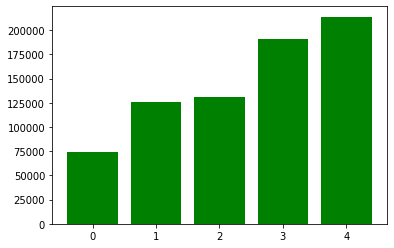

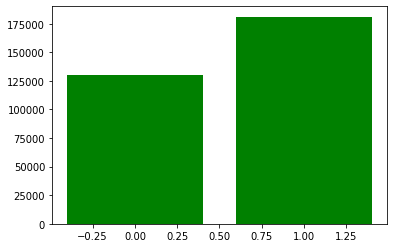

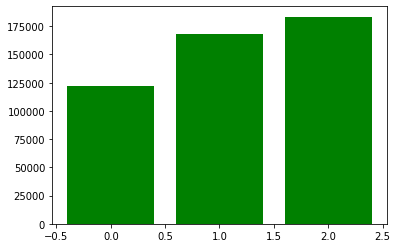

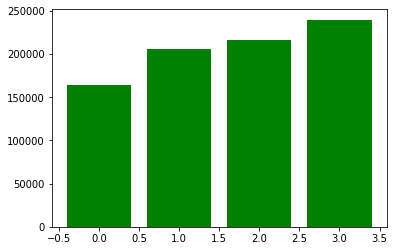

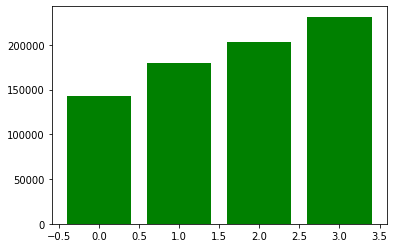

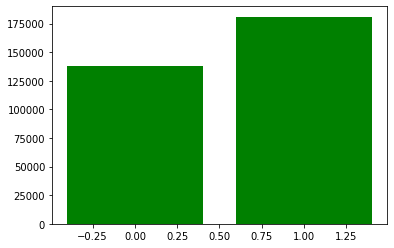

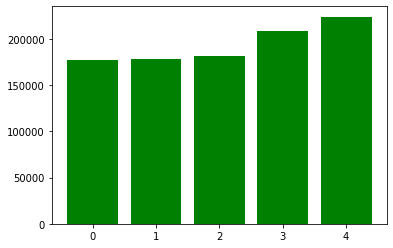

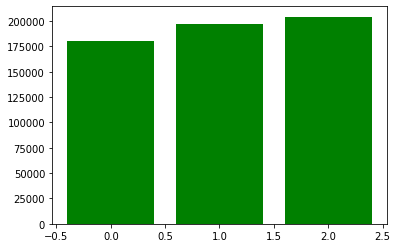

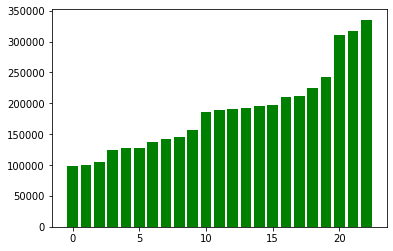

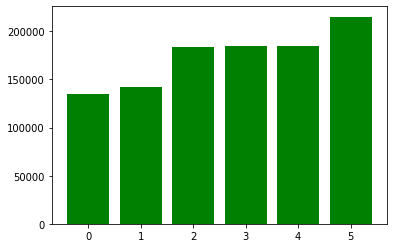

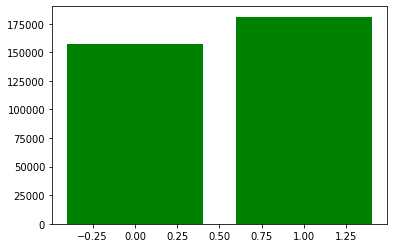

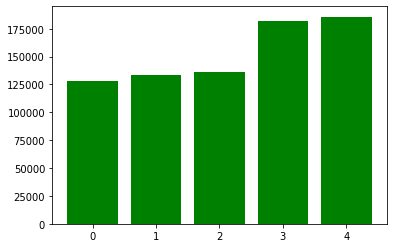

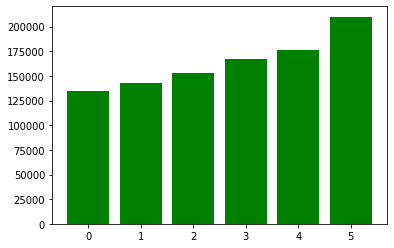

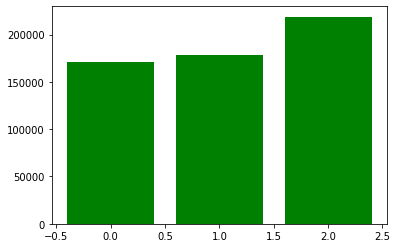

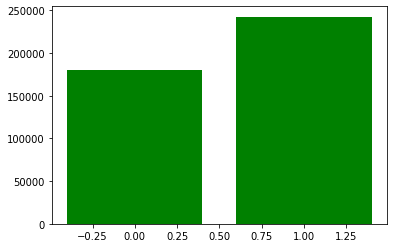

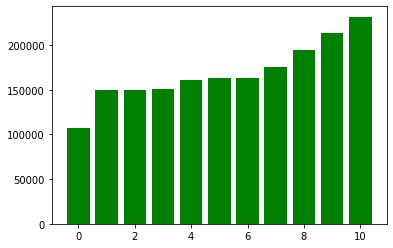

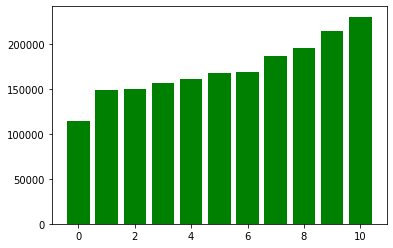

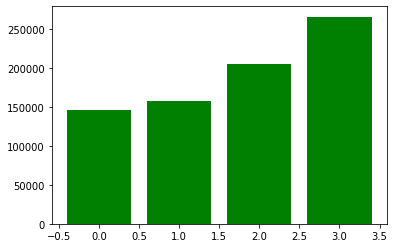

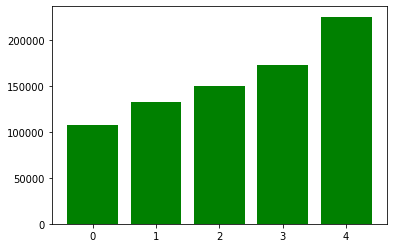

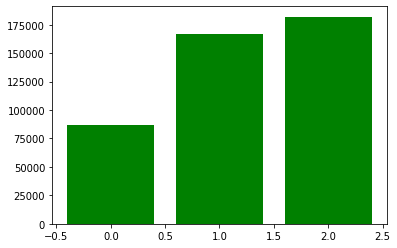

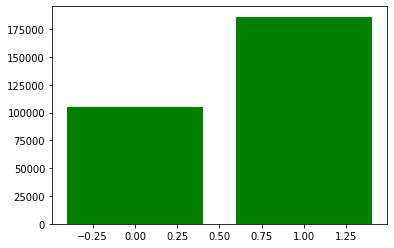

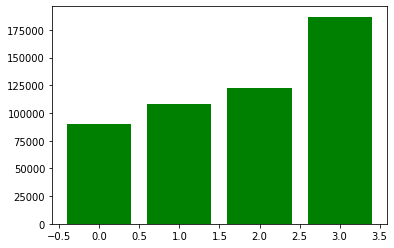

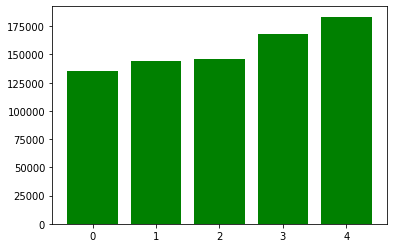

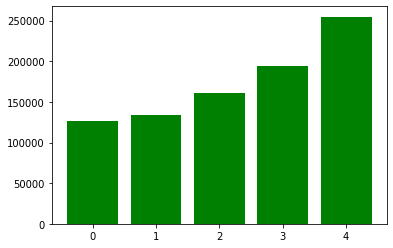

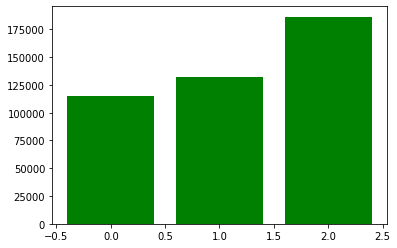

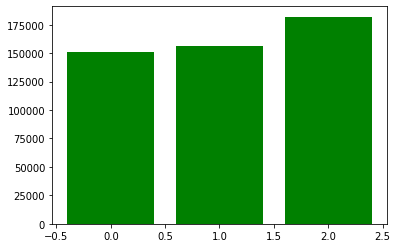

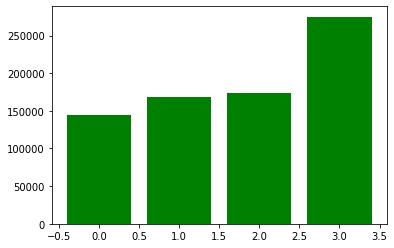

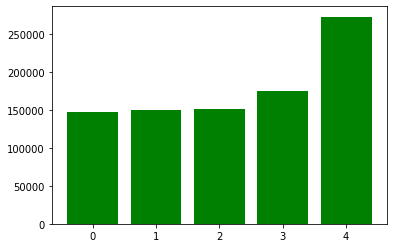

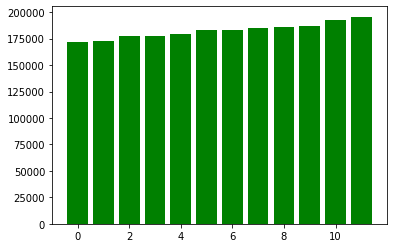

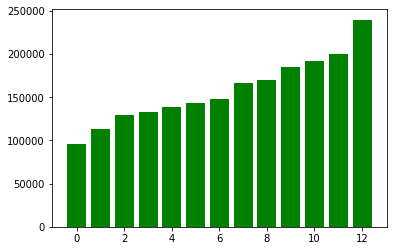

In [24]:
for var in vars_nominal:
    tmp = train.groupby(var)[TARGET].mean()
    #print(tmp)
    plt.bar(x=tmp.index, height=tmp.values, color='green')
    plt.show()

##### To do

1. Cat - fill with "Missing" if there are too many missing values. 
       - fill with most frequent (mode) if there are small % of missing values. 
2. Num - new feature indicating missing
       - fill with mean
3. Time - 
4. Num - transform
5. Cat - map
6. Rare labels
7. Encode cat variables
8. Target - log
9. drop Id, year_sold
10. Scale (min max)
11. save